In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype
#from sklearn.metrics.pairwise import cosine_similarity
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
from tueplots import bundles

plt.rcParams.update(bundles.beamer_moml())
plt.rcParams.update({'figure.dpi': 200})

%matplotlib inline

from utils import *

In [2]:
def print_shape(df):
    print(f"# of observations: {df.shape[0]}") 
    print(f"# of unique mellon_ids: {len(df.mellon_id.unique())}")

# 1. Term Data 

In [3]:
df2 = pd.read_csv("../Data/Student_Term_20220708.csv", encoding = "ISO-8859-1")
df2.rename(columns={"#mellon_id": "mellon_id" }, inplace = True)
df2 = df2.sort_values(["mellon_id","term_code"],ascending=True)
print_shape(df2)


C:\Users\aAlekseeva\AppData\Local\Temp\4\ipykernel_31008\1824453959.py:1: DtypeWarning: Columns (2,4,7,9,10,11,12,18,24,25,27,30,33,34,38,39,40,41,42,45,53,100,105,106,107,108,109,110,112,113,114,118,119,120,121,123,124,125,129,130,131,132,134,135,136,141,142,144,146,150,152,154,157,159,161,164,166,168,169) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv("../Data/Student_Term_20220708.csv", encoding = "ISO-8859-1")


# of observations: 1161671
# of unique mellon_ids: 140054


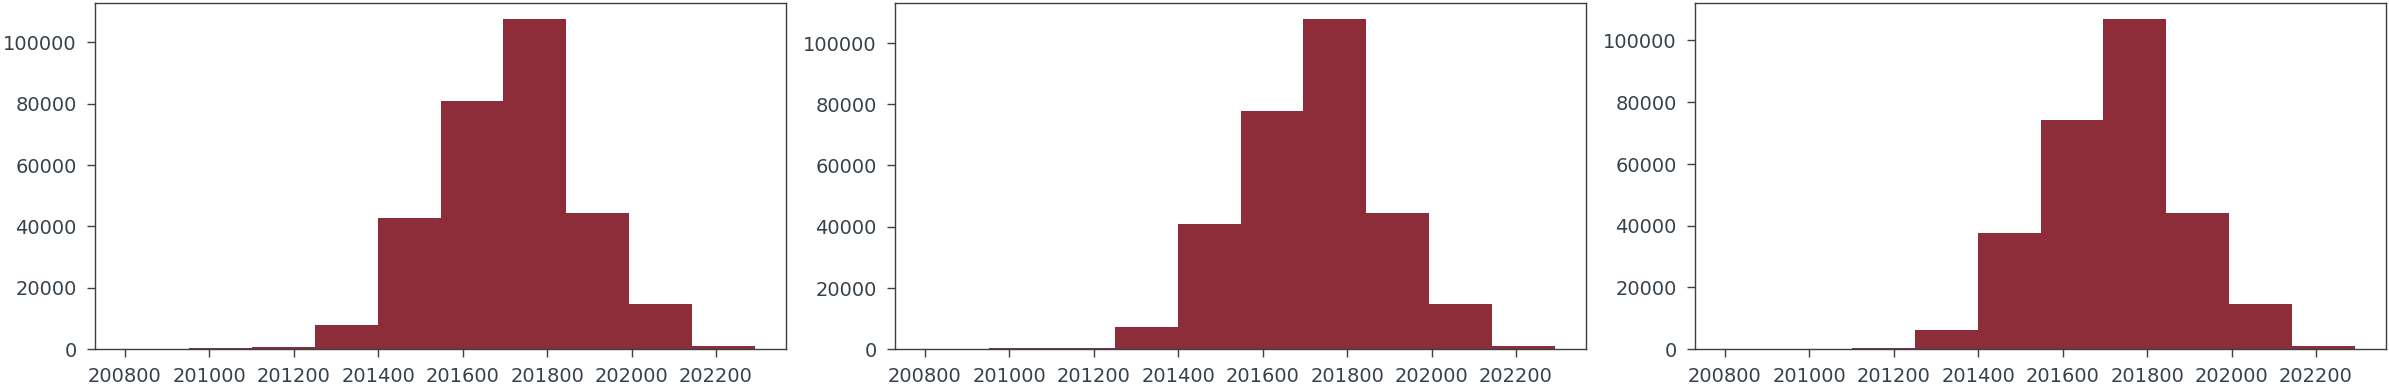

In [5]:
# We want to use only 2016 cohort. And we want to know students from which cohorts studied together with 2016 cohort.
terms = [201692,201703,201714]

fig, ax = plt.subplots(1,3, figsize=(12, 2))

for i,term in enumerate(terms):
    # pick the mellon_ids that studied in the first term in 2016-2017 academic year.
    stud_ids = df2.loc[df2["term_code"] == term,"mellon_id"].unique()
    # pick the terms in which the selected students studied
    term_ids = df2.loc[df2["mellon_id"].isin(stud_ids),"term_code"]
    ax[i].hist(term_ids)

In [6]:
# Delete all missing values from the first major
df2["major_name_1"] = df2["major_name_1"].fillna("undeclared")
df2["major_stem_1"] = df2["major_stem_1"].replace({"0":0,"1":1," ":np.nan})
print_shape(df2)

# Keep only non-summer terms.
df2 = df2.loc[df2["term_code"].astype(str).str.endswith(("92","03","14"))]

# There are many categories to describe unaffiliated and undeclared majors. They are changed to the category "undeclared".
major_undeclared = ["Undeclared","Unaffiliated","Unknown",'Educ Undeclared','Educ Unaffiliated','Arts Undeclared','Public Hlth Unaffil','Human Unaffiliated','I&C Sci Unaffiliated','Soc Sci Unaffiliated','Arts Unaffiliated','Phy Sci Undeclared','Unaffil Undeclared','Socecol Unaffiliated','Educ Unafilliated']
df2["major_name_1"] = ["undeclared" if i in major_undeclared else i for i in df2["major_name_1"]] 
df2["major_declared"] = [0 if i == "undeclared" else 1 for i in df2["major_name_1"]] 
# Create a major_change variable that indicates whether a previous term was different from the current term. 
# If the previous term was undeclared, then the next term cannot be considered major change.
grouped = df2.loc[:,["mellon_id","term_code","major_name_1","major_declared"]].groupby(["mellon_id"])
df2["major_change"] = grouped["major_name_1"].transform(lambda g: [0] + list(1*(~g.eq(g.shift()))[1:] ))
df2["major_declared"] = grouped["major_declared"].transform(lambda g: [0] + list(g.shift())[1:] )
df2["major_change"] = df2["major_change"] * df2["major_declared"]
df2.drop("major_declared", axis=1,inplace=True)

df2["major_change"].value_counts()

# of observations: 1161671
# of unique mellon_ids: 140054


major_change
0.0    1073689
1.0      40349
Name: count, dtype: int64

In [7]:
# Create a variable that indicates a cohort. If term_code == 201692 or 201703 or 201714, then year = 2016.
df2["year"] = [int(term_code[:-2]) if term_code[-2:] =="92" else int(term_code[:-2])-1 for term_code in df2["term_code"].astype(str)]
df2.head()

,mellon_id,group_a,mellon_enr_dt_a,group_b,mellon_enr_dt_b,term_code,term_desc,term_part_code,term_part_desc,enrollment_open_date,...,pell_grant_received,major_minor,Current_Ind,MD5,Effective_Date,End_Effective_Date,MAPPING_NM,CREATED_DTTM,major_change,year
0,162766,1.0,09/01/2019 00:00:00.000,0.0,NaN,201992,Fall 2019,92,Fall,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,04/09/2022 09:08:26.000,0.0,2019
1,162766,1.0,09/01/2019 00:00:00.000,0.0,NaN,202003,Winter 2020,3,Winter,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,04/09/2022 09:08:26.000,0.0,2019
2,162766,1.0,09/01/2019 00:00:00.000,0.0,NaN,202014,Spring 2020,14,Spring,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,04/09/2022 09:08:26.000,0.0,2019
4,162766,1.0,09/01/2019 00:00:00.000,0.0,NaN,202092,Fall 2020,92,Fall,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,04/08/2022 12:20:39.000,0.0,2020
5,162766,1.0,09/01/2019 00:00:00.000,0.0,NaN,202103,Winter 2021,3,Winter,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,04/08/2022 12:20:39.000,0.0,2020


In [9]:
df2 = df2.sort_values(["mellon_id","term_code"]).reset_index(drop=True)
df2_info = (
            df2.loc[:,["mellon_id","term_code","gpa_cumulative","major_graduated_1"]]
            .groupby("mellon_id")
            .agg({"term_code": ["last","min","max","count"],
                  "gpa_cumulative":"last",
                  "major_graduated_1":"last"})
            .reset_index()
            )

df2_info.columns = ["mellon_id","last_term_code","first_term","last_term","total_num_terms",
                    "last_gpa_cum","graduated"]
assert(sum(df2_info["last_term_code"] != df2_info["last_term"])==0)
df2_info = df2_info.drop("last_term_code",axis=1)

# The definition of graduated needs to be reconsidered
df2_info["graduated"] = df2_info["graduated"].fillna(0)
df2_info["graduated"] = [1 if i!=0 else i for i in df2_info["graduated"]] 

#df2_info = df2_info.drop("term_code",axis=1)

df2_info.head()

,mellon_id,first_term,last_term,total_num_terms,last_gpa_cum,graduated
0,162766,201992,202292,10,3.78,0
1,162767,201892,202214,12,3.60,0
2,162768,201992,202114,6,3.41,0
3,162769,201992,202292,10,2.76,0
4,162770,201592,201903,11,3.36,1


In [10]:
print_shape(df2)

# of observations: 1114038
# of unique mellon_ids: 137402


In [11]:
df2_info.shape

(137402, 6)

<Axes: >

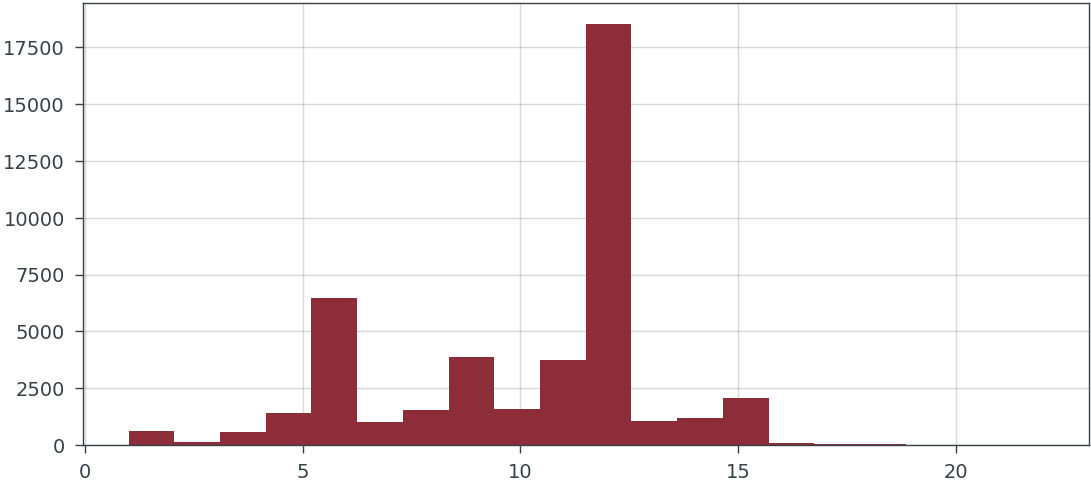

In [12]:
grad = df2_info[df2_info["graduated"]==1]
grad["total_num_terms"].hist(bins=20)

In [13]:
transferred = df2.groupby("mellon_id")[["major_change"]].sum().reset_index()
transferred["major_change"] = 1*(transferred["major_change"]>0)
df2_info = df2_info.merge(transferred,how="left",on="mellon_id")
df2_info.head()

,mellon_id,first_term,last_term,total_num_terms,last_gpa_cum,graduated,major_change
0,162766,201992,202292,10,3.78,0,0
1,162767,201892,202214,12,3.60,0,0
2,162768,201992,202114,6,3.41,0,0
3,162769,201992,202292,10,2.76,0,0
4,162770,201592,201903,11,3.36,1,0


In [14]:
df2_info.to_pickle("../Data/for_network/df2_info.pkl")

In [15]:
df2["US_citizen"] = [1 if i=="US Citizen" else i for i in df2["citizenship"]]
df2["US_citizen"] = [0 if i!=1 and (i==i) else i for i in df2["US_citizen"]]

df2 = df2.loc[:,[
                "mellon_id",
                "term_code",
                "major_change",
                "gpa_term",
                "gpa_cumulative",
                "major_stem_1",
                "major_name_1",
                "major_school_name_1",
                "US_citizen",
                "year"
              ]]

df2.to_pickle("../Data/for_network/df2.pkl")

# 2. Background Data

In [16]:
demo = pd.read_csv("../Data/cleaned_student_background_data(20211110).csv", encoding = "ISO-8859-1")
print(demo.shape)
# Delete the columns with more than a half of missing values
demo = demo.loc[:,demo.isnull().mean(axis=0) < 0.5]
demo = demo.loc[:,[col for col in demo.columns if not col.startswith("ap_")]]
demo.columns

C:\Users\aAlekseeva\AppData\Local\Temp\4\ipykernel_31008\1642832202.py:1: DtypeWarning: Columns (84,85,86,87,88,89) have mixed types. Specify dtype option on import or set low_memory=False.
  demo = pd.read_csv("../Data/cleaned_student_background_data(20211110).csv", encoding = "ISO-8859-1")


(101704, 91)


Index(['mellon_id', 'birth_year', 'gender', 'ethnicity', 'ethnicity_detail',
       'citizenship_app', 'low_income_desc', 'ell', 'city_residence_app',
       'state_residence_app', 'country_residence_app', 'application_status',
       'admitdate', 'hs_gpa', 'uc_read_score', 'uc_math_score',
       'uc_writing_score', 'uc_total_score', 'grad_major_1',
       'grad_major_1_desc', 'female'],
      dtype='object')

In [54]:
demo.loc[demo["admitdate"]=="F17","application_status"].value_counts()

application_status
Freshmen     6456
Transfer     2691
Junior        239
Senior        148
Sophomore      84
Limited        34
2nd Bacc       18
Name: count, dtype: int64

In [49]:
demo["application_status"].value_counts()

application_status
Freshmen     64262
Transfer     14966
Junior        9145
Sophomore     6953
Senior        1772
Limited        605
2nd Bacc        69
Name: count, dtype: int64

In [ ]:
print(demo.shape)
demo_vars = ["female","low_income_desc","hs_gpa","uc_total_score","ethnicity"]
print("\nNumber of missing values (all cohorts):")
for var in demo_vars:
    print(f"{var}: {demo.shape[0]-demo.dropna(subset=[var]).shape[0]}")

freshmen_2016_ids = df2.loc[(df2.year_study=="Freshman") & (df2.term_code == 201692)]["mellon_id"].unique()
demo_2016 = demo.loc[demo["mellon_id"].isin(freshmen_2016_ids)]
print("")
print(demo_2016.shape)
print("\nNumber of missing values (2016 cohort):")
for var in demo_vars:
    print(f"{var}: {demo_2016.shape[0]-demo_2016.dropna(subset=[var]).shape[0]}")

In [17]:
demo["URM"] = [0 if ((val == 'Asian / Asian American') or (val == 'White non-Hispanic')) else val for val in demo["ethnicity"]]
demo["URM"] = [1 if ((val==val) and (val!=0)) else val for val in demo["URM"]]
demo["low_income_desc"] = [1 if i =='Low income' else i for i in demo["low_income_desc"]]
demo["low_income_desc"] = [0 if (i==i) and (i!=1) else i for i in demo["low_income_desc"]]
demo_vars = ["female","low_income_desc","hs_gpa","URM"]
print(demo.shape)

(101704, 22)


In [18]:
demo = demo.loc[:,[
                "mellon_id",
                "female",
                "low_income_desc",
                "hs_gpa",
                "uc_total_score",
                "URM",
                "admitdate",
                "application_status"
              ]]

demo.to_pickle("../Data/for_network/demo.pkl")

# 3. Course Data

In [30]:
df1 =pd.read_csv("../Data/cleaned_student_term_course_section(20211021).csv",low_memory=False)
df1.shape

(6487194, 20)

In [3]:
# Create a unique course indicator (course_id)
df1["term_code"], df1["course_code"], df1["course_section_num"] = df1["term_code"].astype(str), df1["course_code"].astype(str), df1["course_section_num"].astype(str)
df1["course_id"] = df1["term_code"]+"_"+df1["course_code"]+"_"+df1["course_dept_code_and_num"]+"_"+df1["course_section_num"]
df1["term_code"] = df1["term_code"].astype(int)

df1 = df1.dropna(axis=1,how="all") # drop empty columns
df1 = df1.loc[df1["term_code"].astype(str).str.endswith(("92","03","14"))]
df1 = df1.reset_index(drop=True)
df1.shape

(6487183, 18)

In [4]:
df1.columns

Index(['mellon_id', 'term_code', 'term_desc', 'course_code', 'course_title',
       'course_dept_code_and_num', 'course_section_num', 'school_code',
       'dept_code', 'course_level', 'course_type', 'honors_course',
       'online_course', 'credit_code', 'repeat_code', 'units_completed',
       'final_grade', 'course_id'],
      dtype='object')

In [5]:
# Only passed courses
df1 = df1.loc[~(df1["final_grade"].isnull() | df1["final_grade"].isin(["F","I","IP"," ","UR","W","U","NP","NR"]) )] 
df1.shape

(5570540, 18)

In [6]:
df1["year"] = [int(term_code[:-2]) if term_code[-2:] =="92" else int(term_code[:-2])-1 for term_code in df1["term_code"].astype(str)]
df1.head()

,mellon_id,term_code,term_desc,course_code,course_title,course_dept_code_and_num,course_section_num,school_code,dept_code,course_level,course_type,honors_course,online_course,credit_code,repeat_code,units_completed,final_grade,course_id,year
0,162766,201992,Fall 2019,20012,ACADEMIC WRITING,ACENG 20A,M,NaN,NaN,NaN,LEC,NaN,NaN,PN,NAT,5.0,P,201992_20012_ACENG 20A_M,2019
2,162766,201992,Fall 2019,44185,CALCULUS,MATH 2A,H,NaN,NaN,NaN,LEC,NaN,NaN,NAT,NAT,4.0,C,201992_44185_MATH 2A_H,2019
4,162766,201992,Fall 2019,62075,BASIC ECONOMICS II,ECON 20B,A,NaN,NaN,NaN,LEC,NaN,NaN,NAT,NAT,4.0,B+,201992_62075_ECON 20B_A,2019
8,162766,202003,Winter 2020,2030,SOCIAL DANCE,DANCE 14,A,NaN,NaN,NaN,STU,NaN,NaN,NaN,NaN,2.0,P,202003_2030_DANCE 14_A,2019
9,162766,202003,Winter 2020,20026,ACADEMIC WRITING,ACENG 20B,G,NaN,NaN,NaN,LEC,NaN,NaN,NaN,NaN,5.0,P,202003_20026_ACENG 20B_G,2019


In [8]:
df1 = df1.loc[:,[
                "mellon_id",
                "term_code",
                "course_id",
                "year"
              ]]

df1.to_pickle("../Data/for_network/df1.pkl")